# Alunos
Fernando Bianchi - 00335450

Mateus Pletsch - 00338372

# Setup

In [1]:
!git clone https://github.com/Febianchi/fernando-matheus

Cloning into 'fernando-matheus'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 4), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 9.84 MiB | 32.92 MiB/s, done.
Resolving deltas: 100% (4/4), done.


In [2]:
%cd fernando-matheus/

/content/fernando-matheus


In [3]:
!pip install pylhe
#!pip install git+https://github.com/scikit-hep/pylhe.git --quiet
!pip install matplotlib numpy --quiet
!pip install pylhe awkward vector
!gzip -d -k -f {'data/sinal.lhe.gz'} # unpack files
!gzip -d -k -f {'data/fundo.lhe.gz'}

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 655.9/655.9 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 308.0/308.0 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.3/181.3 kB 13.9 MB/s eta 0:00:00


In [4]:
import pylhe
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import itertools
from pathlib import Path
from pprint import pprint
import gzip

# Tabela do PDG

| ID | Partícula | Símbolo | Tipo |
| :---: | :--- | :---: | :--- |
| **1** | Down Quark | $d$ | Quark |
| **2** | Up Quark | $u$ | Quark |
| **3** | Strange Quark | $s$ | Quark |
| **4** | Charm Quark | $c$ | Quark |
| **5** | Bottom Quark | $b$ | Quark |
| **6** | Top Quark | $t$ | Quark |
| | | | |
| **11** | Elétron | $e^-$ | Lépton |
| **12** | Neutrino do Elétron | $\nu_e$ | Lépton |
| **13** | Múon | $\mu^⁻$ | Lépton |
| **14** | Neutrino do Múon | $\nu_\mu$ | Lépton |
| **15** | Tau | $\tau^-$ | Lépton |
| **16** | Neutrino do Tau | $\nu_\tau$ | Lépton |
| | | | |
| **21** | Glúon | $g$ | Bóson |
| **22** | Fóton | $\gamma$ | Bóson |
| **23** | Z Boson | $Z^0$ | Bóson |
| **24** | W Boson | $W^+$ | Bóson |
| **25** | Higgs Boson | $H$ | Bóson |

---
**Regra dos Sinais:**
* **Positivo (+):** Partícula (ex: `6` é o Top).
* **Negativo (-):** Antipartícula (ex: `-6` é o Anti-Top, `-24` é o $W^-$).
* **Exceção:** Glúons e Bosons Z/H/Fóton são suas próprias antipartículas (ou não têm distinção de carga no ID básico), então geralmente aparecem positivos.

In [5]:
plt.style.use('default')
plt.rcParams['figure.figsize'] = (10, 6)

def lhe_to_dataframe(filename, label_processo):
    """
    Lê um arquivo .lhe e retorna um DataFrame onde cada linha é uma partícula.
    Adiciona uma coluna 'label' para distinguir Sinal de Background.
    """
    data = []
    event_id = 0
    in_event = False

    print(f"Lendo arquivo: {filename} ...")

    # Usar gzip.open para lidar com arquivos .gz
    with gzip.open(filename, 'rt') as f: # 'rt' para ler como texto
        for line in f:
            # Controle de bloco de evento
            if '<event>' in line:
                in_event = True
                event_id += 1
                continue
            if '</event>' in line:
                in_event = False
                continue

            # Processamento das linhas de partículas
            if in_event:
                parts = line.strip().split()
                # Validação simples: linhas de partícula têm muitas colunas (aprox 13)
                # A primeira linha pós <event> é cabeçalho do evento (poucas colunas), ignoramos.
                if len(parts) > 6:
                    data.append({
                        'event_id': event_id,
                        'pdg_id': int(parts[0]),
                        'status': int(parts[1]),
                        # Px, Py, Pz, E estão nas colunas 6, 7, 8, 9 (índice base 0)
                        'px': float(parts[6]),
                        'py': float(parts[7]),
                        'pz': float(parts[8]),
                        'e': float(parts[9]),
                        'mass': float(parts[10]),
                        'label': label_processo
                    })

    df = pd.DataFrame(data)
    print(f"Concluído! {len(df)} partículas carregadas.")
    return df

In [6]:
# --- 1. LEITURA ---
df_sinal = lhe_to_dataframe('data/sinal.lhe.gz', 'Sinal')
df_back  = lhe_to_dataframe('data/fundo.lhe.gz', 'Background')

# Concatenando para facilitar cálculos gerais
df_total = pd.concat([df_sinal, df_back], ignore_index=True)

# --- 2a. CONTAGEM DE EVENTOS ---
n_ev_sinal = df_sinal['event_id'].nunique()
n_ev_back = df_back['event_id'].nunique()

print(f"\n--- Resumo de Eventos ---")
print(f"Total Eventos Sinal: {n_ev_sinal}")
print(f"Total Eventos Background: {n_ev_back}")

Lendo arquivo: data/sinal.lhe.gz ...
Concluído! 150000 partículas carregadas.
Lendo arquivo: data/fundo.lhe.gz ...
Concluído! 150000 partículas carregadas.

--- Resumo de Eventos ---
Total Eventos Sinal: 10000
Total Eventos Background: 10000


In [13]:
# 1. Definição do Mapa (conforme você forneceu)
pdg_map = {
    1: 'd', 2: 'u', 3: 's', 4: 'c', 5: 'b', 6: 'Top',
    -1: 'd~', -2: 'u~', -3: 's~', -4: 'c~', -5: 'b~', -6: 'Top~',
    11: 'e-', -11: 'e+', 12: 'nu_e', -12: 'nu_e~',
    13: 'mu-', -13: 'mu+', 14: 'nu_mu', -14: 'nu_mu~',
    15: 'tau-', -15: 'tau+', 16: 'nu_tau', -16: 'nu_tau~',
    21: 'Gluon', 22: 'Photon', 23: 'Z', 24: 'W+', -24: 'W-', 25: 'Higgs'
}

# 2. Criar a coluna 'particle_name' nos DataFrames
# O método .map() pega o valor de 'pdg_id' e busca a chave correspondente no dicionário
df_sinal['particle_name'] = df_sinal['pdg_id'].map(pdg_map)
df_back['particle_name'] = df_back['pdg_id'].map(pdg_map)

# --- 2b. TABELA DE PARTÍCULAS (ATUALIZADA) ---

print("\n--- Conteúdo do SINAL (Status vs PDG vs Nome) ---")
# Agrupamos agora por 3 colunas: status, pdg_id e o nome
# O .fillna('Unknown') garante que se algum ID não estiver no mapa, não quebre o código
print(df_sinal.groupby(['status', 'pdg_id', 'particle_name']).size().to_string())

print("\n--- Conteúdo do BACKGROUND (Status vs PDG vs Nome) ---")
print(df_back.groupby(['status', 'pdg_id', 'particle_name']).size().to_string())


--- Conteúdo do SINAL (Status vs PDG vs Nome) ---
status  pdg_id  particle_name
-1      -4      c~                  53
        -3      s~                  78
        -2      u~                1529
        -1      d~                 945
         1      d                  945
         2      u                 1529
         3      s                   78
         4      c                   53
         21     Gluon            14790
 1      -13     mu+               5065
        -11     e+                4935
        -5      b~               20000
        -4      c~                5099
        -2      u~                4901
         1      d                 4901
         3      s                 5099
         5      b                20000
         12     nu_e              4935
         14     nu_mu             5065
 2      -24     W-               10000
        -6      Top~             10000
         6      Top              10000
         24     W+               10000
         25     Higgs 

In [8]:
# Ou podemos usar diretamente a funcionalidade do pandas, mas sem organizar por grupo:
df_sinal[['pdg_id', 'status']]

,pdg_id,status
0,2,-1
1,-2,-1
2,6,2
3,-6,2
4,25,2
...,...,...
149995,24,2
149996,-11,1
149997,12,1
149998,5,1


## Qual é o processo de sinal?
Sabemos que os arquivos .lhe contêm 10.000 eventos cada. Observamos que o bóson de Higgs aparece 10.000 vezes como estado intermediário, acompanhado pela produção de um par top–antitop. Portanto, esse arquivo corresponde à produção de eventos envolvendo um Higgs intermediário.

Um dos canais de decaimento do Higgs é em bósons W⁺ e W⁻. Isso explica por que também encontramos cerca de 10.000 ocorrências de W⁺ e W⁻, assim como 20.000 quarks b e b̄: eles são produtos diretos dos decaimentos dos Higgs gerados.

A razão das contagens de evntos em outros léptons é porque os bósons W⁺ e W⁻ decaem em léptons (e⁺, μ⁺), neutrinos, e também em quarks leves (d, s, c, u), dependendo do canal de decaimento.

Em resumo, temos a reação:
pp → t ̄t H → bW+ ̄bW- b ̄b

## Qual é o processo do fundo?
Sabemos que os arquivos .lhe contêm 10.000 eventos cada. Observamos que o bóson Z aparece 10.000 vezes como estado intermediário, acompanhado pela produção de um par top–antitop. Portanto, esse arquivo corresponde à produção de eventos envolvendo um bóson Z intermediário.

Os tops decaem naturalmente em bósons W e quarks b. Além disso, o canal de decaimento do bóson Z simulado aqui é em par quark–antiquark (bbˉ). Isso explica por que também encontramos cerca de 10.000 ocorrências de W⁺ e W⁻, assim como 20.000 pares de quarks b e b̄ (40.000 no total): eles são produtos combinados dos decaimentos dos tops e do bóson Z gerado.

A razão das contagens de eventos em outros léptons é porque os bósons W⁺ e W⁻ decaem em léptons (e⁺, μ⁺), neutrinos, e também em quarks leves (d, s, c, u), dependendo do canal de decaimento.

Em resumo, temos a reação:
pp→ t ̄t Z→ bW+ ̄bW− b ̄b

### Pergunta:
Os histogramas representam todos os eventos do arquivo LHE?  
Se não, explique o porquê (por exemplo: presença ou ausência de certas partículas nos eventos).

Não, os histogramas não representam todos os eventos do arquivo LHE. Primeiramente, só foram utilizados os eventos correspondentes aos estados finais, ou seja, os léptons que surgiram de decaimentos intermediários (status==1). Além disso, como solicitado nas instruções, foram ignorados os neutrinos (embora os neutrinos não sejam detectados de qualquer maneira) durante a construção dos histogramas.

# [4] Filtros e Cortes Cinemáticos

<>:44: SyntaxWarning: invalid escape sequence '\e'
<>:45: SyntaxWarning: invalid escape sequence '\p'
<>:44: SyntaxWarning: invalid escape sequence '\e'
<>:45: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-3286502513.py:44: SyntaxWarning: invalid escape sequence '\e'
  plot_comparacao('eta', 'Pseudorapidez $\eta$', (-3, 3))
/tmp/ipython-input-3286502513.py:45: SyntaxWarning: invalid escape sequence '\p'
  plot_comparacao('phi', 'Ângulo Azimutal $\phi$', (-np.pi, np.pi))


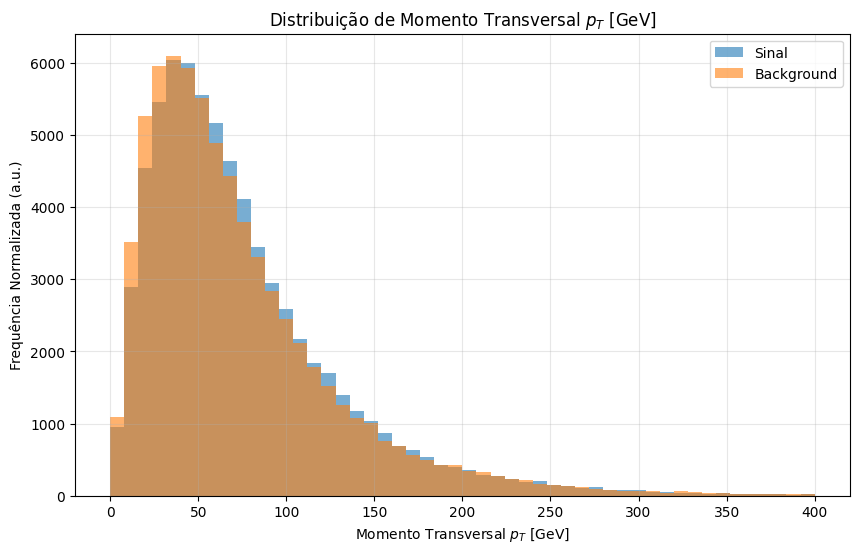

Eventos no plot (Momento Transversal $p_T$ [GeV]): Sinal=70000, Back=70000


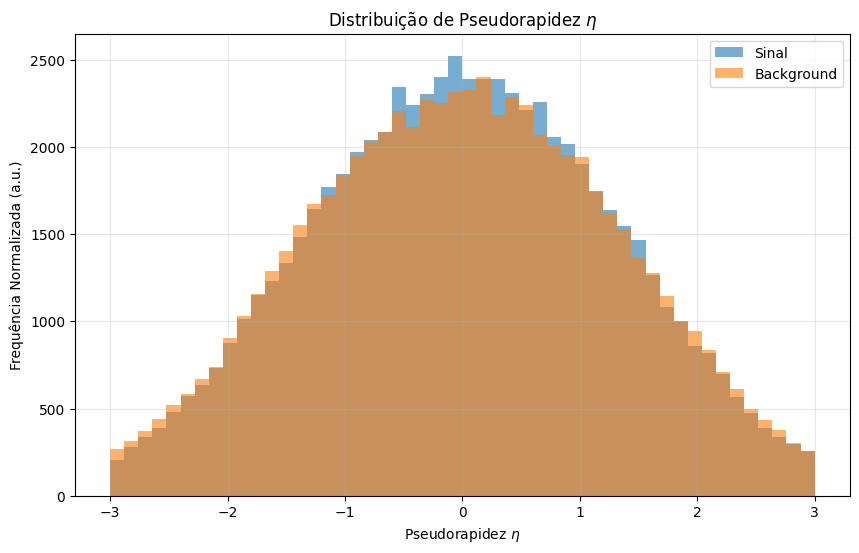

Eventos no plot (Pseudorapidez $\eta$): Sinal=70000, Back=70000


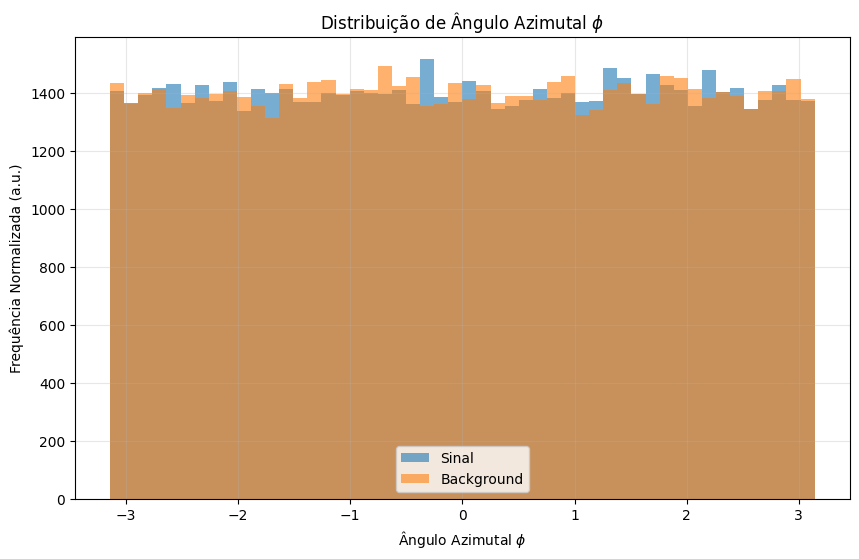

Eventos no plot (Ângulo Azimutal $\phi$): Sinal=70000, Back=70000


In [9]:
# --- CÁLCULOS CINEMÁTICOS (Vetorizados) ---
# pT = raiz(px² + py²)
df_total['pt'] = np.sqrt(df_total['px']**2 + df_total['py']**2)

# Eta (Pseudorapidez) = arcsinh(pz/pt)
# Adicionamos 1e-10 para evitar erro de divisão por zero se pT=0
df_total['eta'] = np.arcsinh(df_total['pz'] / (df_total['pt'] + 1e-10))

# Phi (Azimutal)
df_total['phi'] = np.arctan2(df_total['py'], df_total['px'])

# --- FILTROS DE PLOTAGEM ---
# As instruções pedem:
# 1. Estado Final (status == 1)
# 2. Excluir Neutrinos (PDG IDs: 12, 14, 16 e seus negativos)
neutrinos = [12, 14, 16]
mask_visivel = (df_total['status'] == 1) & (~df_total['pdg_id'].abs().isin(neutrinos))

df_plot = df_total[mask_visivel]

# --- FUNÇÃO PARA PLOTAR HISTOGRAMAS ---
def plot_comparacao(variavel, label_x, range_plot, bins=50):
    plt.figure()

    # Separa os dados filtrados em sinal e background
    dados_sinal = df_plot[df_plot['label'] == 'Sinal'][variavel]
    dados_back  = df_plot[df_plot['label'] == 'Background'][variavel]

    # Plota
    plt.hist(dados_sinal, bins=bins, range=range_plot, alpha=0.6, label='Sinal', histtype='stepfilled')
    plt.hist(dados_back,  bins=bins, range=range_plot, alpha=0.6, label='Background', histtype='stepfilled')

    plt.xlabel(label_x)
    plt.ylabel('Frequência Normalizada (a.u.)')
    plt.title(f'Distribuição de {label_x}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print(f"Eventos no plot ({label_x}): Sinal={len(dados_sinal)}, Back={len(dados_back)}")

# Gerando os Gráficos pedidos
plot_comparacao('pt', 'Momento Transversal $p_T$ [GeV]', (0, 400))
plot_comparacao('eta', 'Pseudorapidez $\eta$', (-3, 3))
plot_comparacao('phi', 'Ângulo Azimutal $\phi$', (-np.pi, np.pi))

### Pergunta:
Os histogramas representam todos os eventos do arquivo LHE?  
Se não, explique o porquê (por exemplo: presença ou ausência de certas partículas nos eventos).

Não, os histogramas não representam todos os eventos do arquivo LHE. Primeiramente, só foram utilizados os eventos correspondentes aos estados finais, ou seja, os léptons que surgiram de decaimentos intermediários (status==1). Além disso, como solicitado nas instruções, foram ignorados os neutrinos (embora os neutrinos não sejam detectados de qualquer maneira) durante a construção dos histogramas.

# [4] Filtros e Cortes Cinemáticos

<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
<>:49: SyntaxWarning: invalid escape sequence '\e'
<>:55: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\p'
<>:46: SyntaxWarning: invalid escape sequence '\e'
<>:48: SyntaxWarning: invalid escape sequence '\e'
<>:49: SyntaxWarning: invalid escape sequence '\e'
<>:55: SyntaxWarning: invalid escape sequence '\p'
<>:56: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipython-input-452653696.py:46: SyntaxWarning: invalid escape sequence '\e'
  ax[1].axvline(ETA_MAX, color='k', linestyle='--', label=f'|$\eta$| < {ETA_MAX}')
/tmp/ipython-input-452653696.py:48: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_title(f"Pseudorapidez ($|\eta| < {ETA_MAX}$)")
/tmp/ipython-input-452653696.py:49: SyntaxWarning: invalid escape sequence '\e'
  ax[1].set_xlabel("$\eta$")
/tmp/ipython-input-452653696.py:55: SyntaxWarning: invalid escape sequence '\p'

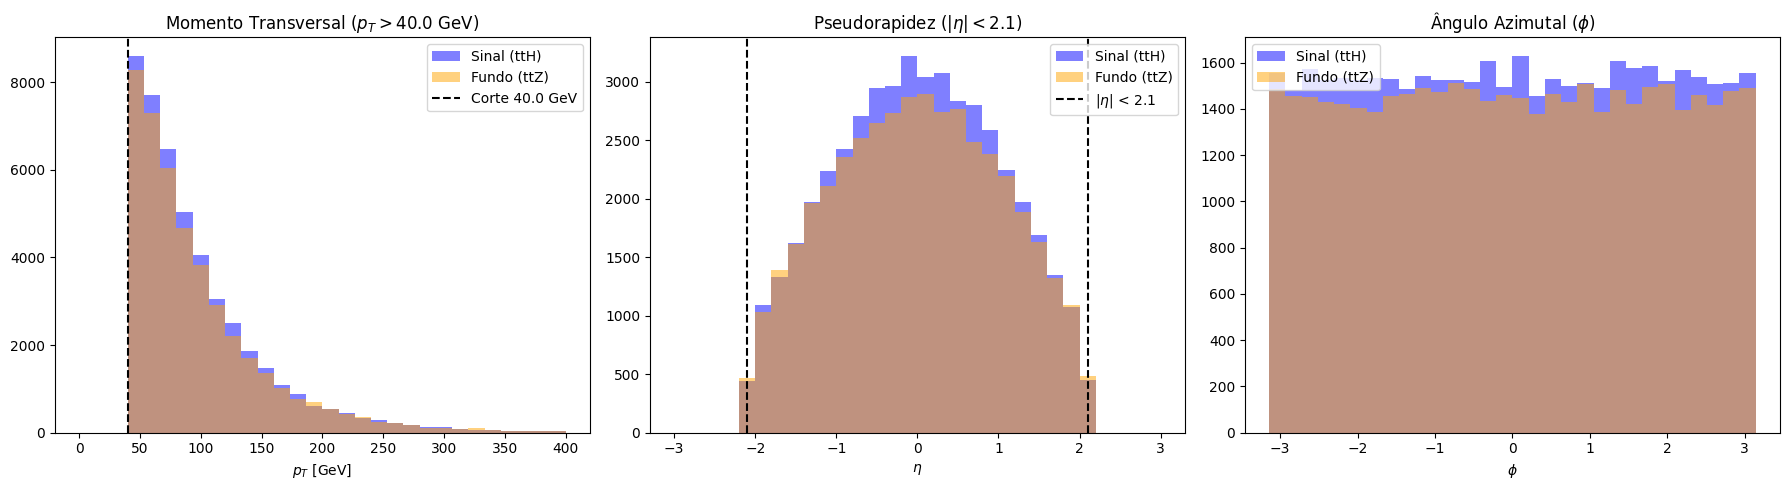


Corte realizado pT > 40.0
Corte realizado em |eta| < 2.1
ANÁLISE DE EFICIÊNCIA DOS CORTES (VIA PANDAS)
SINAL (ttH):
  - Partículas Totais: 70000
  - Partículas Aceitas: 46049
  - Perda: 34.22% das partículas foram cortadas.
------------------------------
FUNDO (ttZ):
  - Partículas Totais: 70000
  - Partículas Aceitas: 43564
  - Perda: 37.77% das partículas foram cortadas.


In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# --- 1. Configuração dos Cortes ---
PT_MIN = 40.0   # GeV
ETA_MAX = 2.1   # Módulo máximo

# --- 2. Aplicação dos Cortes no DataFrame ---
# Criamos uma "máscara" booleana que exige AMBAS as condições (AND lógico '&')
# Condição 1: pT maior que o mínimo
# Condição 2: Valor absoluto de eta menor que o máximo
mask_cortes = (df_plot['pt'] > PT_MIN) & (df_plot['eta'].abs() < ETA_MAX)

# Aplica a máscara para criar o novo dataframe
df_cortado = df_plot[mask_cortes]

# --- 3. Cálculo de Estatísticas (Total vs Aceito) ---
# Contagem Inicial (Antes do corte)
s_tot = len(df_plot[df_plot['label'] == 'Sinal'])
f_tot = len(df_plot[df_plot['label'] == 'Background'])

# Contagem Final (Depois do corte)
s_ok = len(df_cortado[df_cortado['label'] == 'Sinal'])
f_ok = len(df_cortado[df_cortado['label'] == 'Background'])

# --- 4. Plotagem (Usando o DataFrame Cortado) ---
fig, ax = plt.subplots(1, 3, figsize=(18, 5))
kwargs = dict(alpha=0.5, bins=30, ec="k")

# Separando os dados cortados para facilitar o plot
sinal_data = df_cortado[df_cortado['label'] == 'Sinal']
bkg_data = df_cortado[df_cortado['label'] == 'Background']

# --- Plot 1: pT ---
ax[0].hist(sinal_data['pt'], range=(0, 400), color='blue', label='Sinal (ttH)', **kwargs)
ax[0].hist(bkg_data['pt'], range=(0, 400), color='orange', label='Fundo (ttZ)', **kwargs)
ax[0].axvline(PT_MIN, color='k', linestyle='--', label=f'Corte {PT_MIN} GeV')
ax[0].set_title(f"Momento Transversal ($p_T > {PT_MIN}$ GeV)")
ax[0].set_xlabel("$p_T$ [GeV]")
ax[0].legend()

# --- Plot 2: Eta ---
ax[1].hist(sinal_data['eta'], range=(-3, 3), color='blue', label='Sinal (ttH)', **kwargs)
ax[1].hist(bkg_data['eta'], range=(-3, 3), color='orange', label='Fundo (ttZ)', **kwargs)
ax[1].axvline(ETA_MAX, color='k', linestyle='--', label=f'|$\eta$| < {ETA_MAX}')
ax[1].axvline(-ETA_MAX, color='k', linestyle='--')
ax[1].set_title(f"Pseudorapidez ($|\eta| < {ETA_MAX}$)")
ax[1].set_xlabel("$\eta$")
ax[1].legend()

# --- Plot 3: Phi ---
ax[2].hist(sinal_data['phi'], range=(-np.pi, np.pi), color='blue', label='Sinal (ttH)', **kwargs)
ax[2].hist(bkg_data['phi'], range=(-np.pi, np.pi), color='orange', label='Fundo (ttZ)', **kwargs)
ax[2].set_title("Ângulo Azimutal ($\phi$)")
ax[2].set_xlabel("$\phi$")
ax[2].legend()

plt.tight_layout()
plt.show()

# --- 5. Relatório de Eficiência ---
print("\n" + "="*60)
print(f"Corte realizado pT > {PT_MIN}")
print(f"Corte realizado em |eta| < {ETA_MAX}")
print("ANÁLISE DE EFICIÊNCIA DOS CORTES (VIA PANDAS)")
print("="*60)
print(f"SINAL (ttH):")
print(f"  - Partículas Totais: {s_tot}")
print(f"  - Partículas Aceitas: {s_ok}")
print(f"  - Perda: {100*(s_tot-s_ok)/s_tot:.2f}% das partículas foram cortadas.")
print("-" * 30)
print(f"FUNDO (ttZ):")
print(f"  - Partículas Totais: {f_tot}")
print(f"  - Partículas Aceitas: {f_ok}")
print(f"  - Perda: {100*(f_tot-f_ok)/f_tot:.2f}% das partículas foram cortadas.")
print("="*60)